In [1]:
import sys
sys.path.append('D:/CODING/SpeechEncoder/Voice-Encoder')

In [2]:
from speech_encoder_v2 import SpeechEncoderV2
from audio_preprocessing import *
import torch
import torchaudio

## Setting the inputs and preparing the data

In [3]:
wav1 = torchaudio.load('data\LibriSpeech/train-clean-100/19/198/19-198-0000.flac')[0].squeeze(0)
wav2 = torchaudio.load('data\LibriSpeech/train-clean-100/19/198/19-198-0004.flac')[0].squeeze(0)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_device = torch.device("cpu")

In [17]:
from pathlib import Path
wav_fpaths = list(Path("D:\CODING\Voice Encoder\Resemblyzer/audio_data\librispeech_test-other").glob("**/*.flac"))
wav_fpaths

[WindowsPath('D:/CODING/Voice Encoder/Resemblyzer/audio_data/librispeech_test-other/1688/1688-142285-0000.flac'),
 WindowsPath('D:/CODING/Voice Encoder/Resemblyzer/audio_data/librispeech_test-other/1688/1688-142285-0001.flac'),
 WindowsPath('D:/CODING/Voice Encoder/Resemblyzer/audio_data/librispeech_test-other/1688/1688-142285-0002.flac'),
 WindowsPath('D:/CODING/Voice Encoder/Resemblyzer/audio_data/librispeech_test-other/1688/1688-142285-0003.flac'),
 WindowsPath('D:/CODING/Voice Encoder/Resemblyzer/audio_data/librispeech_test-other/1688/1688-142285-0004.flac'),
 WindowsPath('D:/CODING/Voice Encoder/Resemblyzer/audio_data/librispeech_test-other/1688/1688-142285-0005.flac'),
 WindowsPath('D:/CODING/Voice Encoder/Resemblyzer/audio_data/librispeech_test-other/1688/1688-142285-0006.flac'),
 WindowsPath('D:/CODING/Voice Encoder/Resemblyzer/audio_data/librispeech_test-other/1688/1688-142285-0007.flac'),
 WindowsPath('D:/CODING/Voice Encoder/Resemblyzer/audio_data/librispeech_test-other/1688

In [13]:
from itertools import groupby
from tqdm import tqdm
sys.path.append("temp")
from audio import *

speaker_wavs = {speaker: list(map(preprocess_wav, wav_fpaths)) for speaker, wav_fpaths in
                groupby(tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit="wavs"), 
                        lambda wav_fpath: wav_fpath.parent.stem)}

Preprocessing wavs: 100%|██████████| 100/100 [00:02<00:00, 42.94wavs/s]


In [7]:
encoder = SpeechEncoderV2(device,device)
checkpoints = torch.load("Voice-Encoder\models\speech_encoder_transformer\encoder_demo2.pt")
encoder.load_state_dict(checkpoints['model_state'])
encoder.eval()

c:\Users\anike\anaconda3\envs\gpu_environment\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


SpeechEncoderV2(
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=40, out_features=40, bias=True)
        )
        (linear1): Linear(in_features=40, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=40, bias=True)
        (norm1): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
  )
  (linear): Linear(in_features=40, out_features=256, bias=True)
  (relu): ReLU()
  (loss_fn): CrossEntropyLoss()
)

In [8]:
import numpy as np
import audio
from typing import Union, List

def embed_frames_batch(frames_batch):
    """
    Computes embeddings for a batch of mel spectrogram.

    :param frames_batch: a batch mel of spectrogram as a numpy array of float32 of shape
    (batch_size, n_frames, n_channels)
    :return: the embeddings as a numpy array of float32 of shape (batch_size, model_embedding_size)
    """
    frames = torch.from_numpy(frames_batch).to(device)
    encoder.to(device)
    embed = encoder.forward(frames)

    return embed


def compute_partial_slices(n_samples, partial_utterance_n_frames=partials_n_frames,
                           min_pad_coverage=0.75, overlap=0.5):
    """
    Computes where to split an utterance waveform and its corresponding mel spectrogram to obtain
    partial utterances of <partial_utterance_n_frames> each. Both the waveform and the mel
    spectrogram slices are returned, so as to make each partial utterance waveform correspond to
    its spectrogram. This function assumes that the mel spectrogram parameters used are those
    defined in params_data.py.

    The returned ranges may be indexing further than the length of the waveform. It is
    recommended that you pad the waveform with zeros up to wave_slices[-1].stop.

    :param n_samples: the number of samples in the waveform
    :param partial_utterance_n_frames: the number of mel spectrogram frames in each partial
    utterance
    :param min_pad_coverage: when reaching the last partial utterance, it may or may not have
    enough frames. If at least <min_pad_coverage> of <partial_utterance_n_frames> are present,
    then the last partial utterance will be considered, as if we padded the audio. Otherwise,
    it will be discarded, as if we trimmed the audio. If there aren't enough frames for 1 partial
    utterance, this parameter is ignored so that the function always returns at least 1 slice.
    :param overlap: by how much the partial utterance should overlap. If set to 0, the partial
    utterances are entirely disjoint.
    :return: the waveform slices and mel spectrogram slices as lists of array slices. Index
    respectively the waveform and the mel spectrogram with these slices to obtain the partial
    utterances.
    """
    assert 0 <= overlap < 1
    assert 0 < min_pad_coverage <= 1

    samples_per_frame = int((sampling_rate * mel_window_step / 1000))
    n_frames = int(np.ceil((n_samples + 1) / samples_per_frame))
    frame_step = max(int(np.round(partial_utterance_n_frames * (1 - overlap))), 1)

    # Compute the slices
    wav_slices, mel_slices = [], []
    steps = max(1, n_frames - partial_utterance_n_frames + frame_step + 1)
    for i in range(0, steps, frame_step):
        mel_range = np.array([i, i + partial_utterance_n_frames])
        wav_range = mel_range * samples_per_frame
        mel_slices.append(slice(*mel_range))
        wav_slices.append(slice(*wav_range))

    # Evaluate whether extra padding is warranted or not
    last_wav_range = wav_slices[-1]
    coverage = (n_samples - last_wav_range.start) / (last_wav_range.stop - last_wav_range.start)
    if coverage < min_pad_coverage and len(mel_slices) > 1:
        mel_slices = mel_slices[:-1]
        wav_slices = wav_slices[:-1]

    return wav_slices, mel_slices


def embed_utterance(wav, using_partials=True, return_partials=False, **kwargs):
    """
    Computes an embedding for a single utterance.

    # TODO: handle multiple wavs to benefit from batching on GPU
    :param wav: a preprocessed (see audio.py) utterance waveform as a numpy array of float32
    :param using_partials: if True, then the utterance is split in partial utterances of
    <partial_utterance_n_frames> frames and the utterance embedding is computed from their
    normalized average. If False, the utterance is instead computed from feeding the entire
    spectogram to the network.
    :param return_partials: if True, the partial embeddings will also be returned along with the
    wav slices that correspond to the partial embeddings.
    :param kwargs: additional arguments to compute_partial_splits()
    :return: the embedding as a numpy array of float32 of shape (model_embedding_size,). If
    <return_partials> is True, the partial utterances as a numpy array of float32 of shape
    (n_partials, model_embedding_size) and the wav partials as a list of slices will also be
    returned. If <using_partials> is simultaneously set to False, both these values will be None
    instead.
    """
    # Process the entire utterance if not using partials
    if not using_partials:
        frames = audio.wav_to_mel_spectrogram(wav)
        embed = embed_frames_batch(frames[None, ...])[0]
        if return_partials:
            return embed, None, None
        return embed

    # Compute where to split the utterance into partials and pad if necessary
    wave_slices, mel_slices = compute_partial_slices(len(wav), **kwargs)
    max_wave_length = wave_slices[-1].stop
    if max_wave_length >= len(wav):
        wav = np.pad(wav, (0, max_wave_length - len(wav)), "constant")

    # Split the utterance into partials
    frames = audio.wav_to_mel_spectrogram(wav)
    frames_batch = np.array([frames[s] for s in mel_slices])
    partial_embeds = embed_frames_batch(frames_batch)

    # Compute the utterance embedding from the partial embeddings
    # raw_embed = np.mean(partial_embeds, axis=0)
    raw_embed = np.mean(partial_embeds.detach().cpu().numpy(), axis=0)
    embed = raw_embed / np.linalg.norm(raw_embed, 2)

    if return_partials:
        return embed, partial_embeds, wave_slices
    return embed

def embed_speaker(wavs: List[np.ndarray], **kwargs):
        """
        Compute the embedding of a collection of wavs (presumably from the same speaker) by
        averaging their embedding and L2-normalizing it.

        :param wavs: list of wavs a numpy arrays of float32.
        :param kwargs: extra arguments to embed_utterance()
        :return: the embedding as a numpy array of float32 of shape (model_embedding_size,).
        """
        raw_embed = np.mean([embed_utterance(wav, return_partials=False, **kwargs) \
                             for wav in wavs], axis=0)
        return raw_embed / np.linalg.norm(raw_embed, 2)


In [14]:
embeds_a = np.array([embed_utterance(wavs[0]) for wavs in speaker_wavs.values()])
embeds_b = np.array([embed_utterance(wavs[1]) for wavs in speaker_wavs.values()])

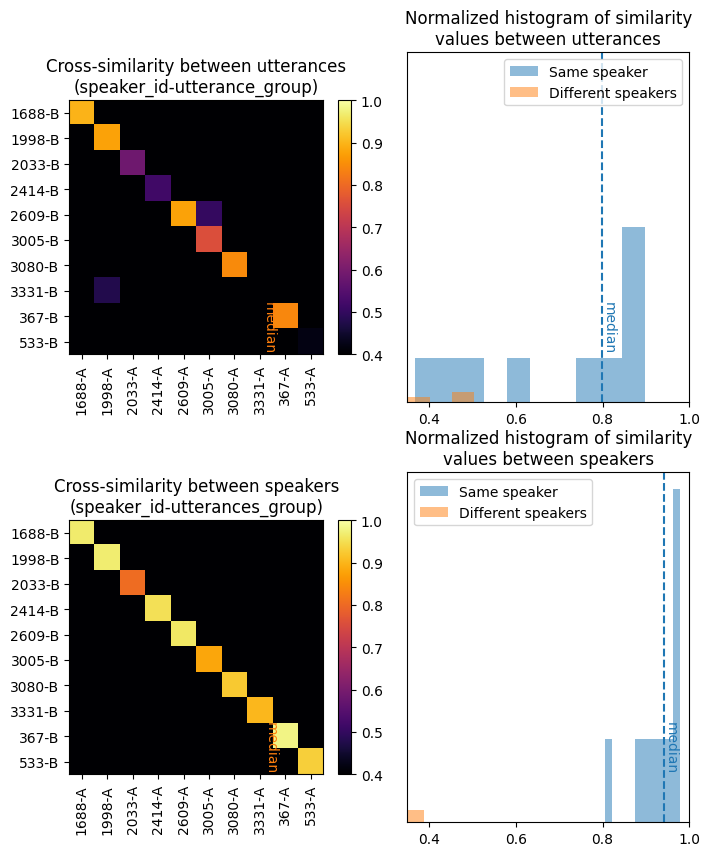

In [16]:
from demo_utils import *

utt_sim_matrix = np.inner(embeds_a, embeds_b)
# Long, detailed version:
utt_sim_matrix2 = np.zeros((len(embeds_a), len(embeds_b)))
for i in range(len(embeds_a)):
    for j in range(len(embeds_b)):
        # The @ notation is exactly equivalent to np.dot(embeds_a[i], embeds_b[i])
        utt_sim_matrix2[i, j] = embeds_a[i] @ embeds_b[j]
assert np.allclose(utt_sim_matrix, utt_sim_matrix2)


## Similarity between two speaker embeddings
# Divide the utterances of each speaker in groups of identical size and embed each group as a
# speaker embedding
spk_embeds_a = np.array([embed_speaker(wavs[:len(wavs) // 2]) \
                         for wavs in speaker_wavs.values()])
spk_embeds_b = np.array([embed_speaker(wavs[len(wavs) // 2:]) \
                         for wavs in speaker_wavs.values()])
spk_sim_matrix = np.inner(spk_embeds_a, spk_embeds_b)


## Draw the plots
fix, axs = plt.subplots(2, 2, figsize=(8, 10))
labels_a = ["%s-A" % i for i in speaker_wavs.keys()]
labels_b = ["%s-B" % i for i in speaker_wavs.keys()]
mask = np.eye(len(utt_sim_matrix), dtype=bool)
plot_similarity_matrix(utt_sim_matrix, labels_a, labels_b, axs[0, 0],
                       "Cross-similarity between utterances\n(speaker_id-utterance_group)")
plot_histograms((utt_sim_matrix[mask], utt_sim_matrix[np.logical_not(mask)]), axs[0, 1],
                ["Same speaker", "Different speakers"], 
                "Normalized histogram of similarity\nvalues between utterances")
plot_similarity_matrix(spk_sim_matrix, labels_a, labels_b, axs[1, 0],
                       "Cross-similarity between speakers\n(speaker_id-utterances_group)")
plot_histograms((spk_sim_matrix[mask], spk_sim_matrix[np.logical_not(mask)]), axs[1, 1],
                ["Same speaker", "Different speakers"], 
                "Normalized histogram of similarity\nvalues between speakers")
plt.show()